### `Ali Almalki`

In this tutorial I am going to build a neural network to predict whether a pet will be adopted or not.

In [15]:
# Import all required libraries 
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras import layers

In [2]:
# Check out TensorFlow version 
tf.__version__

'2.9.2'

In [3]:
# Check out whether we are using a GPU or not
!nvidia-smi -L

GPU 0: Tesla T4 (UUID: GPU-53833423-e02f-42a6-a814-8b6e132a775d)


### Load the dataset

In [4]:
dataset_url = "http://storage.googleapis.com/download.tensorflow.org/data/petfinder-mini.zip"
csv_file = "datasets/petfinder-mini/petfinder-mini.csv"

# Get the CSV file using keras utils get_file function 
tf.keras.utils.get_file("petfinder_mini.zip", dataset_url,
                        extract=True, cache_dir=".")

1668792/1668792 [==============================] - 0s 0us/step


'./datasets/petfinder_mini.zip'

In [6]:
# Read the dataset into a dataframe 
df = pd.read_csv(csv_file)
df.head()

,Type,Age,Breed1,Gender,Color1,Color2,MaturitySize,FurLength,Vaccinated,Sterilized,Health,Fee,Description,PhotoAmt,AdoptionSpeed
0,Cat,3,Tabby,Male,Black,White,Small,Short,No,No,Healthy,100,Nibble is a 3+ month old ball of cuteness. He ...,1,2
1,Cat,1,Domestic Medium Hair,Male,Black,Brown,Medium,Medium,Not Sure,Not Sure,Healthy,0,I just found it alone yesterday near my apartm...,2,0
2,Dog,1,Mixed Breed,Male,Brown,White,Medium,Medium,Yes,No,Healthy,0,Their pregnant mother was dumped by her irresp...,7,3
3,Dog,4,Mixed Breed,Female,Black,Brown,Medium,Short,Yes,No,Healthy,150,"Good guard dog, very alert, active, obedience ...",8,2
4,Dog,1,Mixed Breed,Male,Black,No Color,Medium,Short,No,No,Healthy,0,This handsome yet cute boy is up for adoption....,3,2


### Let's become one with the data😉
Exploratory Data Analysis (EDA)

In [9]:
print(f"Dataset Shape: {df.shape}")
print(f"Dataset Features: {df.columns}")
print(f"Dataset Information: {df.info()}")

Dataset Shape: (11537, 15)
Dataset Features: Index(['Type', 'Age', 'Breed1', 'Gender', 'Color1', 'Color2', 'MaturitySize',
       'FurLength', 'Vaccinated', 'Sterilized', 'Health', 'Fee', 'Description',
       'PhotoAmt', 'AdoptionSpeed'],
      dtype='object')
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11537 entries, 0 to 11536
Data columns (total 15 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   Type           11537 non-null  object
 1   Age            11537 non-null  int64 
 2   Breed1         11537 non-null  object
 3   Gender         11537 non-null  object
 4   Color1         11537 non-null  object
 5   Color2         11537 non-null  object
 6   MaturitySize   11537 non-null  object
 7   FurLength      11537 non-null  object
 8   Vaccinated     11537 non-null  object
 9   Sterilized     11537 non-null  object
 10  Health         11537 non-null  object
 11  Fee            11537 non-null  int64 
 12  Description    11528 n

In [8]:
# Dataset Description
df.describe()

,Age,Fee,PhotoAmt,AdoptionSpeed
count,11537.000000,11537.000000,11537.000000,11537.000000
mean,11.743434,23.957268,3.610211,2.486522
std,19.324221,80.024226,3.145872,1.173275
min,0.000000,0.000000,0.000000,0.000000
25%,2.000000,0.000000,2.000000,2.000000
50%,4.000000,0.000000,3.000000,2.000000
75%,12.000000,0.000000,5.000000,4.000000
max,255.000000,2000.000000,30.000000,4.000000


### Create a target variable

"The original task in Kaggle's PetFinder.my Adoption Prediction competition was to predict the speed at which a pet will be adopted (e.g. in the first week, the first month, the first three months, and so on).

In this tutorial, you will simplify the task by transforming it into a binary classification problem, where you simply have to predict whether a pet was adopted or not.

After modifying the AdoptionSpeed column, `0` will indicate the pet was `not adopted`, and `1` will indicate it was `adopted`."

* `0`: `not adopted`
* `1`: `adopted`

In [10]:
df["target"] = np.where(df["AdoptionSpeed"]==4, 0, 1)

# Drop unused features in our classification
df = df.drop(columns=["AdoptionSpeed", "Description"])

In [11]:
# Check the dataframe again 
df.head()

,Type,Age,Breed1,Gender,Color1,Color2,MaturitySize,FurLength,Vaccinated,Sterilized,Health,Fee,PhotoAmt,target
0,Cat,3,Tabby,Male,Black,White,Small,Short,No,No,Healthy,100,1,1
1,Cat,1,Domestic Medium Hair,Male,Black,Brown,Medium,Medium,Not Sure,Not Sure,Healthy,0,2,1
2,Dog,1,Mixed Breed,Male,Brown,White,Medium,Medium,Yes,No,Healthy,0,7,1
3,Dog,4,Mixed Breed,Female,Black,Brown,Medium,Short,Yes,No,Healthy,150,8,1
4,Dog,1,Mixed Breed,Male,Black,No Color,Medium,Short,No,No,Healthy,0,3,1


In [12]:
# Check target distribution 
df.target.value_counts()

1    8457
0    3080
Name: target, dtype: int64

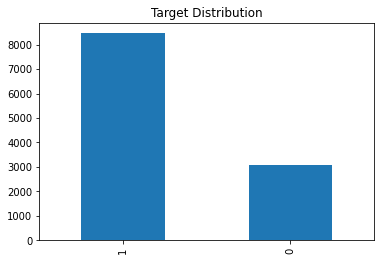

In [26]:
# Plot target distribution
plt.title("Target Distribution")
df["target"].value_counts().plot(kind="bar");

### Data Split 

"The dataset is in a single pandas DataFrame. Split it into training, validation, and test sets using a, for example, 80:10:10 ratio, respectively:


"

In [28]:
# Split the dataset into training, validation and testing sets
train, val, test = np.split(df.sample(frac=1), [int(0.8 * len(df)), int(0.9 * len(df))])

# Check each set length
print(len(train), "Training Examples")
print(len(val), "Validation Examples")
print(len(test), "Test Examples")

9229 Training Examples
1154 Validation Examples
1154 Test Examples


### Create an input pipeline using `tf.data()`

"Next, create a utility function that converts each training, validation, and test set DataFrame into a tf.data.Dataset, then shuffles and batches the data."

In [29]:
def df_to_dataset(df, shuffle=True, batch_size=32):
  df = df.copy()
  labels = df.pop("target")

  df = {key: value[:,tf.newaxis] for key, value in df.items()}
  dataset = tf.data.Dataset.from_tensor_slices((dict(df), labels))
  if shuffle:
    dataset = dataset.shuffle(buffer_size=len(df))
  dataset = dataset.batch(batch_size)
  dataset = dataset.prefetch(batch_size)

  return dataset

### Build the model using Keras preprocessing layers

"In this tutorial, you will use the following four preprocessing layers to demonstrate how to perform preprocessing, structured data encoding, and feature engineering:

* `tf.keras.layers.Normalization`: Performs feature-wise normalization of input features.
* `tf.keras.layers.CategoryEncoding`: Turns integer categorical features into one-hot, multi-hot, or tf-idf dense representations.
* `tf.keras.layers.StringLookup`: Turns string categorical values into integer indices.
* `tf.keras.layers.IntegerLookup`: Turns integer categorical values into integer indices.
You can learn more about the available layers in the Working with preprocessing layers guide.


### Numerical Columns

In [32]:
# Normalize numerical features in the dataset

def get_normalization_layer(name, dataset):

  # Create a Normalization layer for the feature.
  normalizer = layers.Normalization(axis=None)

  # Prepare a Dataset that only yields the feature.
  feature_dataset = dataset.map(lambda x, y: x[name])

  # Learn the statistics of the data.
  normalizer.adapt(feature_dataset)

  return normalizer

In [34]:
# Check the train set
train.head()

,Type,Age,Breed1,Gender,Color1,Color2,MaturitySize,FurLength,Vaccinated,Sterilized,Health,Fee,PhotoAmt,target
8064,Cat,9,Domestic Medium Hair,Female,Yellow,White,Large,Short,No,Yes,Healthy,0,4,1
1618,Dog,36,Poodle,Female,Cream,No Color,Small,Short,Yes,Yes,Healthy,0,1,0
300,Cat,3,Domestic Short Hair,Female,Black,Brown,Medium,Short,No,No,Healthy,0,3,1
7138,Cat,17,Domestic Medium Hair,Female,Gray,No Color,Medium,Medium,Not Sure,Yes,Healthy,0,2,1
1525,Dog,6,Mixed Breed,Female,Black,No Color,Medium,Short,Yes,No,Healthy,0,2,0


In [36]:
train_dataset = df_to_dataset(train, batch_size=5)
[(train_features, label_batch)] = train_dataset.take(1)
print('Every feature:', list(train_features.keys()))
print('A batch of ages:', train_features['Age'])
print('A batch of targets:', label_batch )

Every feature: ['Type', 'Age', 'Breed1', 'Gender', 'Color1', 'Color2', 'MaturitySize', 'FurLength', 'Vaccinated', 'Sterilized', 'Health', 'Fee', 'PhotoAmt']
A batch of ages: tf.Tensor(
[[12]
 [36]
 [ 2]
 [ 3]
 [ 6]], shape=(5, 1), dtype=int64)
A batch of targets: tf.Tensor([1 0 1 0 0], shape=(5,), dtype=int64)


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  """


In [38]:
# Test the function 

photo_count_col = train_features["PhotoAmt"]
layer = get_normalization_layer("PhotoAmt", train_dataset)
layer(photo_count_col)

<tf.Tensor: shape=(5, 1), dtype=float32, numpy=
array([[-1.1408787 ],
       [-0.8247062 ],
       [ 0.43998381],
       [-0.8247062 ],
       [-0.8247062 ]], dtype=float32)>

### Categorical Columns

In [41]:
# Check Type 
train["Type"].value_counts()

Dog    5270
Cat    3959
Name: Type, dtype: int64

In [42]:
def get_category_encoding_layer(name, dataset, dtype, max_tokens=None):

  # Create a layer that turns strings into integer indices.
  if dtype == "string":
    index = layers.StringLookup(max_tokens=max_tokens)
  # Otherwise, create a layer that turns integer values into integer indices.
  else:
    index = layers.IntegerLookup(max_tokens=max_tokens)

  # Prepare a `tf.data.Dataset` that only yields the feature.
  feature_dataset = dataset.map(lambda x, y: x[name])

  # Learn the set of possible values and assign them a fixed integer index.
  index.adapt(feature_dataset)

  # Encode the integer indices.
  encoder = layers.CategoryEncoding(num_tokens=index.vocabulary_size())

  # Apply multi-hot encoding to the indices. The lambda function captures the
  # layer, so you can use them, or include them in the Keras Functional model later.
  
  return lambda feature: encoder(index(feature))

In [44]:
test_type_col = train_features['Type']
test_type_layer = get_category_encoding_layer(name='Type',
                                              dataset=train_dataset,
                                              dtype='string')
test_type_layer(test_type_col)

<tf.Tensor: shape=(5, 3), dtype=float32, numpy=
array([[0., 1., 0.],
       [0., 1., 0.],
       [0., 1., 0.],
       [0., 1., 0.],
       [0., 1., 0.]], dtype=float32)>

In [46]:
test_age_col = train_features['Age']
test_age_layer = get_category_encoding_layer(name='Age',
                                             dataset=train_dataset,
                                             dtype='int64',
                                             max_tokens=5)
test_age_layer(test_age_col)

<tf.Tensor: shape=(5, 5), dtype=float32, numpy=
array([[1., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0.],
       [0., 0., 1., 0., 0.],
       [1., 0., 0., 0., 0.]], dtype=float32)>

In [47]:
# Create the batches 
batch_size = 32

train_dataset = df_to_dataset(train, batch_size=batch_size)
val_dataset= df_to_dataset(val, shuffle=False, batch_size=batch_size)
test_dataset = df_to_dataset(test, shuffle=False, batch_size=batch_size)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  """


In [48]:
# Normalize the numerical features (the number of pet photos and the adoption fee), and add them to one list of inputs called encoded_features:

all_inputs = []
encoded_features = []

# Numerical features.
for header in ['PhotoAmt', 'Fee']:
  numeric_col = tf.keras.Input(shape=(1,), name=header)
  normalization_layer = get_normalization_layer(header, train_dataset)
  encoded_numeric_col = normalization_layer(numeric_col)
  all_inputs.append(numeric_col)
  encoded_features.append(encoded_numeric_col)


In [50]:
age_col = tf.keras.Input(shape=(1,), name='Age', dtype='int64')

encoding_layer = get_category_encoding_layer(name='Age',
                                             dataset=train_dataset,
                                             dtype='int64',
                                             max_tokens=5)
encoded_age_col = encoding_layer(age_col)
all_inputs.append(age_col)
encoded_features.append(encoded_age_col)

In [51]:
categorical_cols = ['Type', 'Color1', 'Color2', 'Gender', 'MaturitySize',
                    'FurLength', 'Vaccinated', 'Sterilized', 'Health', 'Breed1']

for header in categorical_cols:
  categorical_col = tf.keras.Input(shape=(1,), name=header, dtype='string')
  encoding_layer = get_category_encoding_layer(name=header,
                                               dataset=train_dataset,
                                               dtype='string',
                                               max_tokens=5)
  encoded_categorical_col = encoding_layer(categorical_col)
  all_inputs.append(categorical_col)
  encoded_features.append(encoded_categorical_col)

### Build the model using the Keras Functional API

"The next step is to create a model using the Keras Functional API. For the first layer in your model, merge the list of feature inputs—encoded_features—into one vector via concatenation with `tf.keras.layers.concatenate` "

In [52]:
encoded_features

[<KerasTensor: shape=(None, 1) dtype=float32 (created by layer 'normalization_2')>,
 <KerasTensor: shape=(None, 1) dtype=float32 (created by layer 'normalization_3')>,
 <KerasTensor: shape=(None, 5) dtype=float32 (created by layer 'category_encoding_2')>,
 <KerasTensor: shape=(None, 3) dtype=float32 (created by layer 'category_encoding_3')>,
 <KerasTensor: shape=(None, 5) dtype=float32 (created by layer 'category_encoding_4')>,
 <KerasTensor: shape=(None, 5) dtype=float32 (created by layer 'category_encoding_5')>,
 <KerasTensor: shape=(None, 3) dtype=float32 (created by layer 'category_encoding_6')>,
 <KerasTensor: shape=(None, 4) dtype=float32 (created by layer 'category_encoding_7')>,
 <KerasTensor: shape=(None, 4) dtype=float32 (created by layer 'category_encoding_8')>,
 <KerasTensor: shape=(None, 4) dtype=float32 (created by layer 'category_encoding_9')>,
 <KerasTensor: shape=(None, 4) dtype=float32 (created by layer 'category_encoding_10')>,
 <KerasTensor: shape=(None, 4) dtype=fl

# Create the model using the Keras Functional API

For the first layer in your model, merge the list of feature inputs—encoded_features—into one vector via concatenation with `tf.keras.layers.concatenate` 

In [53]:
all_inputs

[<KerasTensor: shape=(None, 1) dtype=float32 (created by layer 'PhotoAmt')>,
 <KerasTensor: shape=(None, 1) dtype=float32 (created by layer 'Fee')>,
 <KerasTensor: shape=(None, 1) dtype=int64 (created by layer 'Age')>,
 <KerasTensor: shape=(None, 1) dtype=string (created by layer 'Type')>,
 <KerasTensor: shape=(None, 1) dtype=string (created by layer 'Color1')>,
 <KerasTensor: shape=(None, 1) dtype=string (created by layer 'Color2')>,
 <KerasTensor: shape=(None, 1) dtype=string (created by layer 'Gender')>,
 <KerasTensor: shape=(None, 1) dtype=string (created by layer 'MaturitySize')>,
 <KerasTensor: shape=(None, 1) dtype=string (created by layer 'FurLength')>,
 <KerasTensor: shape=(None, 1) dtype=string (created by layer 'Vaccinated')>,
 <KerasTensor: shape=(None, 1) dtype=string (created by layer 'Sterilized')>,
 <KerasTensor: shape=(None, 1) dtype=string (created by layer 'Health')>,
 <KerasTensor: shape=(None, 1) dtype=string (created by layer 'Breed1')>]

In [54]:
# 1. Create the model
all_features = tf.keras.layers.concatenate(encoded_features)
x = tf.keras.layers.Dense(32, activation="relu")(all_features)
x = tf.keras.layers.Dropout(0.5)(x)
output = tf.keras.layers.Dense(1)(x)

model = tf.keras.Model(all_inputs, output)

# 2. Compile the model 
model.compile(loss="BinaryCrossentropy", 
              optimizer="adam", 
              metrics=["accuracy"])

# 3. Fit the model to the training set
model.fit(train_dataset, 
          epochs=15,
          validation_data=val_dataset)

Epoch 1/15
289/289 [==============================] - 6s 9ms/step - loss: 4.5042 - accuracy: 0.5864 - val_loss: 3.6403 - val_accuracy: 0.7348
Epoch 2/15
289/289 [==============================] - 2s 8ms/step - loss: 3.0866 - accuracy: 0.6890 - val_loss: 2.9014 - val_accuracy: 0.7444
Epoch 3/15
289/289 [==============================] - 2s 8ms/step - loss: 1.9148 - accuracy: 0.6607 - val_loss: 0.8550 - val_accuracy: 0.6629
Epoch 4/15
289/289 [==============================] - 2s 8ms/step - loss: 1.1493 - accuracy: 0.6023 - val_loss: 0.7701 - val_accuracy: 0.6958
Epoch 5/15
289/289 [==============================] - 3s 10ms/step - loss: 1.0378 - accuracy: 0.6067 - val_loss: 0.7640 - val_accuracy: 0.7036
Epoch 6/15
289/289 [==============================] - 2s 8ms/step - loss: 0.9517 - accuracy: 0.6198 - val_loss: 0.7883 - val_accuracy: 0.7244
Epoch 7/15
289/289 [==============================] - 2s 8ms/step - loss: 0.8976 - accuracy: 0.6047 - val_loss: 0.7415 - val_accuracy: 0.6014
Epoch

In [55]:
# Check model structure 
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 Age (InputLayer)               [(None, 1)]          0           []                               
                                                                                                  
 Type (InputLayer)              [(None, 1)]          0           []                               
                                                                                                  
 Color1 (InputLayer)            [(None, 1)]          0           []                               
                                                                                                  
 Color2 (InputLayer)            [(None, 1)]          0           []                               
                                                                                              

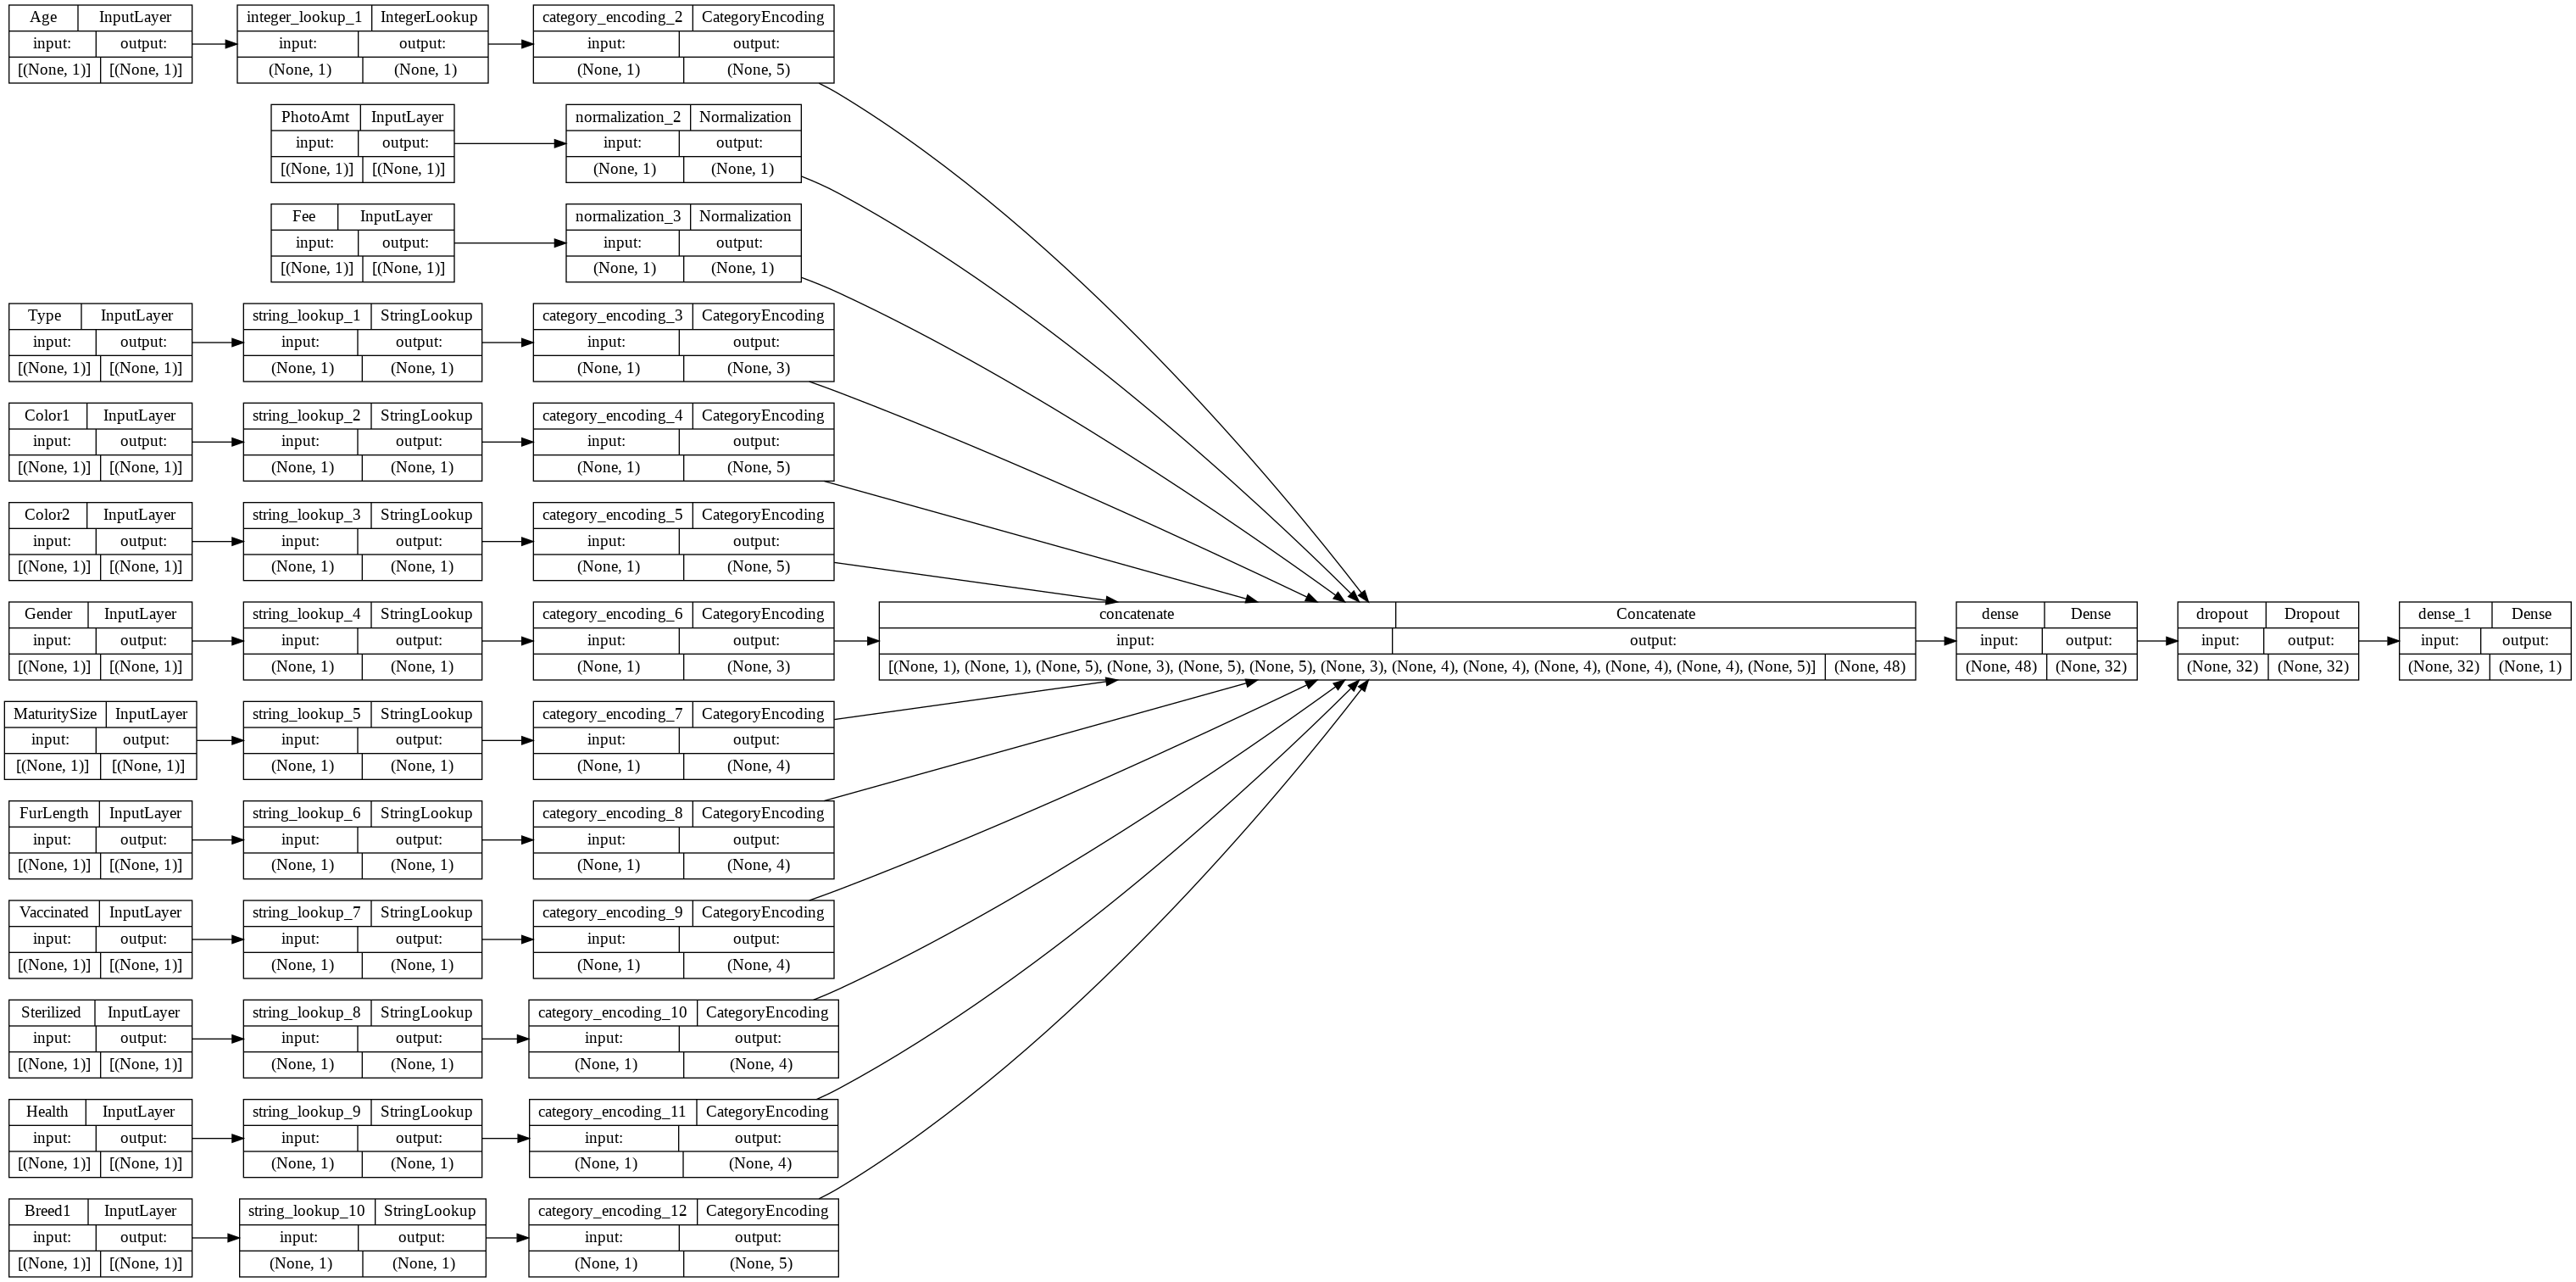

In [56]:
# Visualize the connectivity graph
tf.keras.utils.plot_model(model, show_shapes=True, rankdir="LR")

In [57]:
# Model Evaluation 
loss, accuracy = model.evaluate(test_dataset)
print("Model Accuracy", accuracy)

37/37 [==============================] - 0s 10ms/step - loss: 0.6770 - accuracy: 0.5511
Model Accuracy 0.5511265397071838


In [58]:
# Save the model 
model.save("my_pet_classifier")
reloaded_model = tf.keras.models.load_model("my_pet_classifier")

### Make a prediction 

"To get a prediction for a new sample, you can simply call the Keras Model.predict method. There are just two things you need to do:

Wrap scalars into a list so as to have a batch dimension (Models only process batches of data, not single samples).
Call `tf.convert_to_tensor` on each feature."

In [59]:
sample = {
    'Type': 'Cat',
    'Age': 3,
    'Breed1': 'Tabby',
    'Gender': 'Male',
    'Color1': 'Black',
    'Color2': 'White',
    'MaturitySize': 'Small',
    'FurLength': 'Short',
    'Vaccinated': 'No',
    'Sterilized': 'No',
    'Health': 'Healthy',
    'Fee': 100,
    'PhotoAmt': 2,
}

input_dict = {name: tf.convert_to_tensor([value]) for name, value in sample.items()}
predictions = reloaded_model.predict(input_dict)
prob = tf.nn.sigmoid(predictions[0])

print(
    "This particular pet had a %.1f percent probability "
    "of getting adopted." % (100 * prob)
)

1/1 [==============================] - 0s 410ms/step
This particular pet had a 61.1 percent probability of getting adopted.


### References: 

* [Classify structured data using Keras preprocessing layers](https://www.tensorflow.org/tutorials/structured_data/preprocessing_layers)

* [Dataset Source](https://www.kaggle.com/c/petfinder-adoption-prediction)